In [8]:
%matplotlib inline
import os
import pickle

import numpy as np
import torch

import matplotlib.pyplot as plt
import umap
from sklearn.preprocessing import StandardScaler

from midi_processing import mid2dat_anna, dat2mid_anna
from datasets import *
from main import Trainer

# Load a workdir

In [9]:
workdir = 'test'
device = 'cpu'

config  = pickle.load(open(f"{workdir}/config.pkl", "rb"))
model = Trainer(workdir, config, device=device)
model.model.eval()

FileNotFoundError: [Errno 2] No such file or directory: 'test/config.pkl'

# NLL Loss

In [16]:
print("Best validation loss:", model.ckpt['best_loss'])

Best validation loss: tensor(6.0861)


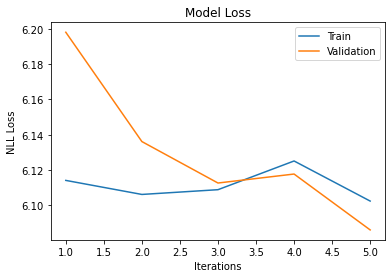

In [18]:
step_size = config.train.print_every
num_steps = len(model.ckpt['train_losses'])
xs = np.arange(step_size, num_steps*step_size+1, step_size)
plt.title("Model Loss")
plt.xlabel("Iterations")
plt.ylabel("NLL Loss")
plt.plot(xs, model.ckpt['train_losses'], label="Train")
plt.plot(xs, model.ckpt['valid_losses'], label="Validation")
plt.legend()
plt.show()

# Sample generation

In [5]:
def seq_gen(inp_file, method='max'):
    '''
    method:
        'max' - Sample argmax from model output
        'beam' - Perform beam search on model outputs
    '''
    inp=getInputSample(inp_file)
    dat2mid_anna(list(map(tok_mapping, inp[0])), fname=os.path.join(workdir, "inp.mid"))

    if method == 'max':
        mid_data=seq_gen_max(inp,inp_file)
        return(mid_data)
    elif method == 'beam':
        pass # TODO
    
def seq_gen_max(inp,inp_file):
    repr = model.model.encoder(inp, repr=True)
    mem  = model.model.mem_fn(repr)
    out = torch.tensor([[MASK_IDX]]).to(device)
    for i in range(repr.shape[1]):
        with torch.no_grad():
            out_logits = model.model(inp, out, mem)[0,-1,:]
        new_tok = torch.multinomial(torch.nn.functional.softmax(out_logits, dim=0), num_samples=1)
        if new_tok[0] == 389:
            break
        out = torch.cat((out, new_tok.unsqueeze(0)), dim=-1)
    data=list(map(tok_mapping, out[0].cpu()))

    filename=inp_file.replace('Datasets/asap-dataset/','Store/Generated')
    filename=filename.replace(".mid","_out.mid")


    mid_data=dat2mid_anna(data, fname=os.path.join(workdir, "out.mid"))
    mid_data.write(filename)
    return(mid_data)

def getInputSample(inp_file):
    seq_len = config.transformer.seq_len
    inp_tokens=mid2dat_anna(inp_file)
    # sample random starting point and ending of length seq_len
    start = np.random.randint(0, len(inp_tokens)-seq_len)
    end = start + seq_len

    inp_tokens = inp_tokens[start:end]

    inp_midi_data=dat2mid_anna(inp_tokens)
    filename=inp_file.replace('Datasets/asap-dataset/','Store/Generated')
    filename=filename.replace(".mid","_inp.mid")

    
    inp_midi_data.write(filename)

    inp= torch.tensor(list(map(key_mapping, inp_tokens))).unsqueeze(0).to(device)

    return(inp_tokens)

In [6]:
import pickle
from tqdm import tqdm
def generateFromPickle(pickle_file, method='max',mode="score2perf"):
    with open(pickle_file, 'rb') as f:
        data = pickle.load(f)

        performance_files=list(data.keys())
        score_files=[]
        for performance_file in performance_files:
            perf_list=performance_file.split('/')
            score_file="/".join(perf_list[:-1])+'/'+"midi_score.mid"
            score_files.append(score_file)
        
        if mode=="score2perf":
            for score_file in tqdm(score_files):
                seq_gen(score_file, method=method)        
        else:
            for performance_file in tqdm(performance_files):
                seq_gen(performance_file, method=method)


In [7]:
file="Store/asap-dataset/test_data.pickle"

generateFromPickle(file, method='max',mode="perf2score")

  0%|          | 0/208 [00:00<?, ?it/s]


NameError: name 'config' is not defined

# UMAP Embedding

In [23]:
dataset = MidiMaskDataset("maestro_test.pickle", mask_probs=config.mask_probs)

Num-songs 178
Num-songs after discarding 178


In [57]:
# Get encoder outputs and metadata

data = torch.empty((0, config.transformer.embed_dim))
labels = []
for i in range(100):
    batch = dataset.get_batch(config.train.batch_size)
    inp = batch["inp"].to(device)
    meta = batch["meta"]
    with torch.no_grad():
        repr = model.model.encoder(inp, repr=True)
        mem  = model.model.mem_fn(repr) # (batch, num_moments, embed_dim)
        data = torch.cat((data, mem[:,0,:]), dim=0)
        labels = labels + [x['canonical_composer'] for x in meta]
labels = np.array(labels)

In [58]:
reducer = umap.UMAP()
reduce_data = StandardScaler().fit_transform(data)
reduce_data = reducer.fit_transform(reduce_data)

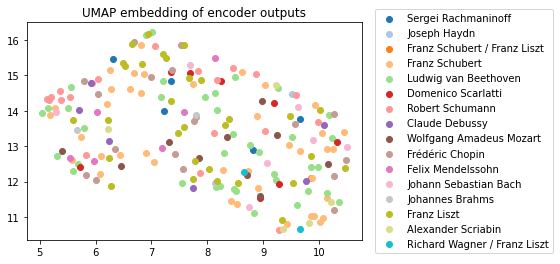

In [59]:
distinct_labels = list(set(labels))
colors = plt.cm.get_cmap('tab20', len(distinct_labels)+1)
cdict = dict(zip(distinct_labels, [colors(i) for i in range(len(distinct_labels))]))
for val in distinct_labels:
    ix = np.where(labels == val)
    plt.scatter(reduce_data[ix,0], reduce_data[ix,1], color=cdict[val], label=val)
plt.title("UMAP embedding of encoder outputs")
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.show()